In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [34]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
import random as ran
from functools import reduce
import warnings
import json

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs
from src import get_col_list
from IPython.display import clear_output, Markdown, display

In [5]:
# 1. load_excel
data_path = "data/apt_all.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [6]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트4-104-101,아파트4-104-1301,아파트4-104-1501,아파트4-104-301,아파트4-105-102,아파트4-105-103,아파트4-105-1102,아파트4-105-1104,아파트4-105-601,아파트4-105-803
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,335,363,181,216,270,518,230,279,161,156
2,251,481,177,218,397,297,339,197,348,288,...,309,339,146,184,267,344,208,236,167,150
3,255,424,203,222,378,303,349,202,357,368,...,313,372,152,236,268,417,212,272,166,155
4,252,355,180,230,368,278,298,188,346,365,...,266,346,149,210,268,421,208,243,156,148
5,230,357,258,203,414,270,418,156,320,265,...,305,256,151,222,287,349,185,284,165,180


In [8]:
with open("data/test_data.json", "r") as f:
    test_data_info = json.load(f, encoding='utf8')

PUBLIC_PERCENTAGE = test_data_info['공용부 percentage']
_month = test_data_info['월']
h_cols = test_data_info['가구구성']

## 데이터

In [14]:
_m = m.copy()
_m = _m[h_cols]

month_df = pd.DataFrame(_m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

households_kWh = month_df['usage (kWh)'].sum()
households_count = len(month_df)
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

APT_mean = round(APT / households_count)
households_mean = round(month_df['usage (kWh)'].mean())

month_df.head(10)

,name,usage (kWh)
0,아파트1-104-1208,7
1,아파트1-103-606,398
2,아파트1-104-705,84
3,아파트1-101-303,356
4,아파트3-101-603,196
5,아파트3-102-305,204
6,아파트1-103-1706,336
7,아파트2-2-1301,141
8,아파트3-103-707,204
9,아파트3-103-2018,216


In [21]:
calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
fee = calc.fee

## 기본요금

In [26]:
nugin_dist = pd.DataFrame(columns=['가구 수'])

for step, _f in enumerate(fee):
    now_kWh = _f[0]
    if step < 2:
        next_kWh = fee[step + 1][0]
        count = len(month_df[(month_df['usage (kWh)'] >= now_kWh) &\
                             (month_df['usage (kWh)'] < next_kWh)])
        nugin_dist.loc['{} 단계'.format(step + 1)] = [count]
                    
    else:
        count = len(month_df[month_df['usage (kWh)'] >= now_kWh])
        nugin_dist.loc['{} 단계'.format(step + 1)] = [count]

nugin_dist['기본요금'] = [_[2] for _ in fee]
nugin_dist['토탈'] = nugin_dist['가구 수'] * nugin_dist['기본요금']

print("세대부 토탈 액 {}원".format(format(nugin_dist['토탈'].sum(), ",")))
nugin_dist.head()

세대부 토탈 액 452,150원


,가구 수,기본요금,토탈
1 단계,197,730,143810
2 단계,187,1260,235620
3 단계,12,6060,72720


In [29]:
for step, _f in enumerate(fee):
    if APT_mean < _f[1]:
        apt_step = step
        apt_basic = _f[2] * households_count
        break

print("APT 토탈 액 {}원".format(format(apt_basic, ",")))

APT 토탈 액 498,960원


In [30]:
public_basic = apt_basic - nugin_dist['토탈'].sum()
print("공용부 기본요금 {}원".format(format(public_basic, ",")))

공용부 기본요금 46,810원


## 전력량요금

### 전력량요금 수거현황판

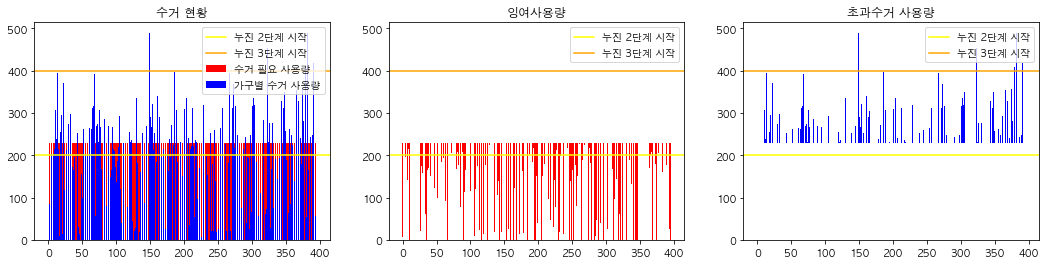

In [32]:
plt.figure(figsize=(18,4))

# 수거현황
ax_1 = plt.subplot(1,3,1)

ax_1.bar(range(0, len(month_df)), APT_mean, color='r')
ax_1.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')

ax_1.axhline(200, color='yellow')
ax_1.axhline(400, color='orange')

ax_1.set_title("수거 현황")
ax_1.legend(["누진 2단계 시작","누진 3단계 시작",'수거 필요 사용량', '가구별 수거 사용량'], loc='upper right')

# 잉여사용량
ax_2 = plt.subplot(1,3,2)

ax_2.bar(range(0, len(month_df)), APT_mean, color='r')
ax_2.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='white')

ax_2.axhline(200, color='yellow')
ax_2.axhline(400, color='orange')
ax_2.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_2.set_title("잉여사용량")

# 초과수거 사용량
ax_3 = plt.subplot(1,3,3)

ax_3.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')
ax_3.bar(range(0, len(month_df)), APT_mean, color='white')

ax_3.axhline(200, color='yellow')
ax_3.axhline(400, color='orange')
ax_3.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_3.set_title("초과수거 사용량")

plt.show()

### 전력량요금 수거현황 Table

In [52]:
all_col_needed = np.array(get_col_list(APT_mean, calc.fee)) * len(month_df)
col_households = np.array([get_col_list(usage, calc.fee) for usage in month_df['usage (kWh)']]).sum(axis=0)

col_needed = np.array(get_col_list(APT_mean, calc.fee))
surplus_col = np.zeros(3)
excess_col = np.zeros(3)

for usage in month_df['usage (kWh)']:
    col_chk = col_needed - get_col_list(usage, calc.fee)
    
    for idx, chk in enumerate(col_chk):
        if chk > 0:
            surplus_col[idx] += chk
        else:
            excess_col[idx] += abs(chk)
            
er_info = pd.DataFrame(np.array([all_col_needed, col_households,
         surplus_col, excess_col]).reshape(-1, 3).astype("int"), columns=['누진 1단계', '누진 2단계', '누진 3단계'],
            index=['수거 필요 사용량',' 수거 사용량', '잉여 사용량', '초과수거 사용량'])
er_info.head()

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,79200,11088,0
수거 사용량,54641,17167,415
잉여 사용량,24559,5980,0
초과수거 사용량,0,12059,415


In [60]:
elec_rate_fee = np.array([_[3] for _ in fee])

er_1 = (er_info.loc['잉여 사용량'].values * elec_rate_fee).round()
er_2 = (er_info.loc['초과수거 사용량'].values * elec_rate_fee).round()

public_elec_rate = int(er_1.sum() - er_2.sum())
public_elec_rate

847734

# 기후환경요금, 연료비조정액 예측

In [74]:
public_env = round((APT - households_kWh) * 5.3)
public_fuel = round((APT - households_kWh) * 3) * -1

print()
display(Markdown("공용부 기후환경요금 = ({}kWh(APT 총 사용량) - {}kWh(세대부 총 사용량)) * 5.3원 = **{}원**".format(
    format(APT, ","),
    format(households_kWh, ","),
    format(public_env, ",")
)))
display(Markdown("공용부 연료비조정액 = ({}kWh(APT 총 사용량) - {}kWh(세대부 총 사용량)) * 3원 = **{}원**".format(
    format(APT, ","),
    format(households_kWh, ","),
    format(public_fuel, ",")
)))
print()

공용부 기후환경요금 = (90,279kWh(APT 총 사용량) - 72,223kWh(세대부 총 사용량)) * 5.3원 = **95,697원**

공용부 연료비조정액 = (90,279kWh(APT 총 사용량) - 72,223kWh(세대부 총 사용량)) * 3원 = **-54,168원**

## 전기요금계 예측

In [80]:
elec_bill = pd.DataFrame([public_basic, public_elec_rate, public_env, public_fuel]).T

elec_bill.columns=['기본요금', '전력량요금', '기후환경요금', '연료비조정액']
elec_bill.index = ['공용부']

elec_bill['전기요금계'] = elec_bill.sum(axis=1)
elec_bill['부가가치세'] = elec_bill['전기요금계'] * 0.1
elec_bill['전력산업기반기금'] = elec_bill['전기요금계'] * 0.037
elec_bill['최종청구금액'] = elec_bill[['전기요금계','부가가치세','전력산업기반기금']].sum(axis=1)

elec_bill.head()

,기본요금,전력량요금,기후환경요금,연료비조정액,전기요금계,부가가치세,전력산업기반기금,최종청구금액
공용부,46810,847734,95697,-54168,936073,93607.3,34634.701,1064315.001


In [101]:
print()
display(Markdown("공용부 예측 최종청구금액 : **{}원**".format(format(elec_bill['최종청구금액'].values[0], ","))))
display(Markdown("공용부 실제 최종청구금액 : **{}원**".format(format(calc.public_bill, ","))))
display(Markdown("오차 : **{}원**".format(format(abs(calc.public_bill - elec_bill['최종청구금액'].values[0]), ","))))
print()

공용부 예측 최종청구금액 : **1,064,315.0010000002원**

공용부 실제 최종청구금액 : **1,391,330원**

오차 : **327,014.99899999984원**

## 필수사용량보장공제

In [100]:
guarantee_cnt = len(month_df[month_df['usage (kWh)'] <= 200])
guarantee_cnt

guarantee = guarantee_cnt * 2500
guarantee

elec_bill_2 = elec_bill[elec_bill.columns[:4]].copy()
elec_bill_2['세대부 필수사용량보장공제'] = guarantee

elec_bill_2['전기요금계'] = elec_bill_2.sum(axis=1)
elec_bill_2['부가가치세'] = elec_bill_2['전기요금계'] * 0.1
elec_bill_2['전력산업기반기금'] = elec_bill_2['전기요금계'] * 0.037
elec_bill_2['최종청구금액'] = elec_bill_2[['전기요금계','부가가치세','전력산업기반기금']].sum(axis=1)

elec_bill_2

,기본요금,전력량요금,기후환경요금,연료비조정액,세대부 필수사용량보장공제,전기요금계,부가가치세,전력산업기반기금,최종청구금액
공용부,46810,847734,95697,-54168,492500,1428573,142857.3,52857.201,1624287.501


In [102]:
print()
display(Markdown("공용부 예측 최종청구금액 : **{}원**".format(format(elec_bill_2['최종청구금액'].values[0], ","))))
display(Markdown("공용부 실제 최종청구금액 : **{}원**".format(format(calc.public_bill, ","))))
display(Markdown("오차 : **{}원**".format(format(abs(calc.public_bill - elec_bill_2['최종청구금액'].values[0]), ","))))
print()

공용부 예측 최종청구금액 : **1,624,287.5010000002원**

공용부 실제 최종청구금액 : **1,391,330원**

오차 : **232,957.50100000016원**